# **Stock Predictor**

#### **Jonah Silverstein**

# Summary

#### Description:
This machine learning project focuses on developing a regression model that can predict the closing prices of Tesla stock. This will be done by analyzing trends in the stock data, engineering technical indicator features, and hypertuning our models. Additionally, this project will compare the effectiveness of several regression algorithms on the accuracy and generalization of the model.

#### Details:
 - Predicting stock prices is a regression problem, as stock prices are numerical values and thus a continuous variable.
 - This project will analyze a dataset of statistics relating to Tesla's stock price, and will train a model to predict the next-day closing price.

# Procedure

## 1. Importing Libraries

In [1]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data preprocessing and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# regression algorithms
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor

# feature engineering and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

## 2. Data Exploration

In [2]:
# downloading six years of stock data, from 2019-08-01 to 2025-08-01
# dates are adjusted for values that are going to be dropped later
df = yf.download('TSLA', '2017-05-22', '2025-08-02')
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000
2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000
2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500
2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000
2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000
...,...,...,...,...,...
2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800
2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2061 entries, 2017-05-22 to 2025-08-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, TSLA)   2061 non-null   float64
 1   (High, TSLA)    2061 non-null   float64
 2   (Low, TSLA)     2061 non-null   float64
 3   (Open, TSLA)    2061 non-null   float64
 4   (Volume, TSLA)  2061 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 96.6 KB


In [4]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
count,2061.000000,2061.000000,2061.000000,2061.000000,2.061000e+03
mean,159.057821,162.698725,155.268293,159.110646,1.243284e+08
std,118.900383,121.727637,116.052289,119.049135,7.576226e+07
min,11.931333,12.445333,11.799333,12.073333,2.940180e+07
25%,23.006666,23.333332,22.620667,23.012667,7.762060e+07
50%,182.580002,186.160004,178.220001,182.850006,1.034160e+08
75%,249.979996,254.770004,243.483337,249.366669,1.423554e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


In [5]:
print(f"Duplicate Rows: {df.duplicated().sum()}")
print(f"Null Values:\n{df.isnull().sum()}")

Duplicate Rows: 0
Null Values:
Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64


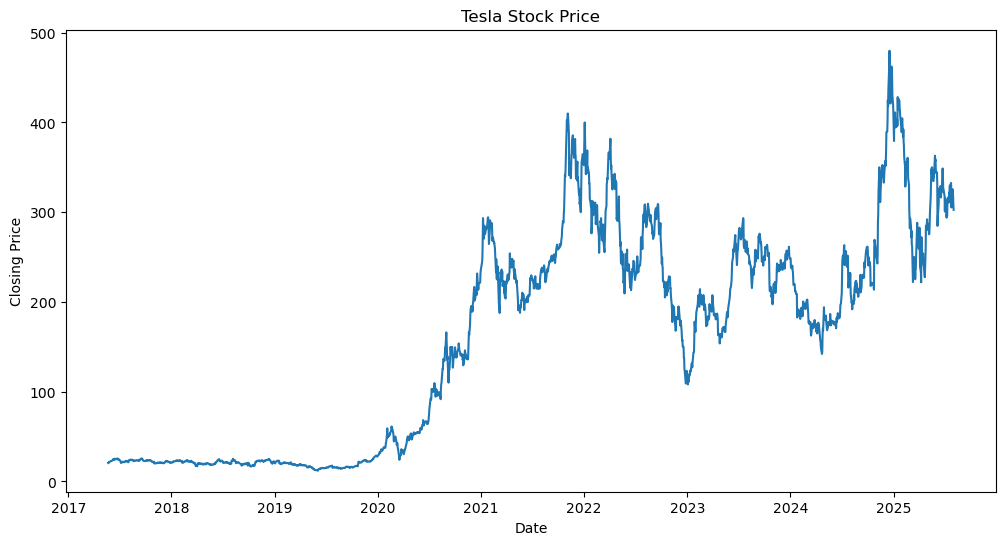

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Tesla Stock Price")
plt.show()

## 3. Data Preprocessing

In [7]:
# renaming columns
df.columns = df.columns.get_level_values(0)
df.columns.name = None
df = df.reset_index()

In [8]:
# adding target column (value of stock on next trading day)
df["Target"] = df["Close"].shift(-1)
# df["Target"] = df["Close"].pct_change().shift(-1)
df = df.dropna()
df

,Date,Close,High,Low,Open,Volume,Target
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000
...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989


## 4. Feature Engineering

### Lag Features

In [9]:
close = df["Close"]

In [10]:
# adding lag features (necessary for certain algorithms)
df["past_1"] = close.shift(1)
df["past_5"] = close.shift(5)
df["past_10"] = close.shift(10)
df["past_25"] = close.shift(25)
df["past_50"] = close.shift(50)

In [11]:
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,past_25,past_50
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334,NaN,NaN,NaN,NaN,NaN
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334,20.690001,NaN,NaN,NaN,NaN
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000,20.257334,NaN,NaN,NaN,NaN
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001,20.681334,NaN,NaN,NaN,NaN
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000,21.122000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,305.299988,329.649994,313.510010,322.049988,334.070007
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,316.059998,328.489990,316.899994,322.160004,347.679993
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,325.589996,332.109985,310.779999,348.679993,342.820007
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,321.200012,332.559998,321.670013,340.470001,349.980011


### Trend Indicators

In [12]:
# adding moving averages
df["moving_avg_10"] = close.rolling(window=10).mean()
df["moving_avg_25"] = close.rolling(window=25).mean()
df["moving_avg_50"] = close.rolling(window=50).mean()

In [13]:
# adding exponential moving averages
df["exp_moving_avg_10"] = close.ewm(span=10, adjust=False).mean()
df["exp_moving_avg_25"] = close.ewm(span=25, adjust=False).mean()
df["exp_moving_avg_50"] = close.ewm(span=50, adjust=False).mean()

In [14]:
# adding moving average convergence divergence
ema_12 = close.ewm(span=12, adjust=False).mean()
ema_26 = close.ewm(span=26, adjust=False).mean()

df["macd"] = ema_12 - ema_26
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

In [15]:
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,past_25,past_50,moving_avg_10,moving_avg_25,moving_avg_50,exp_moving_avg_10,exp_moving_avg_25,exp_moving_avg_50,macd,macd_signal
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.690001,20.690001,20.690001,0.000000,0.000000
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334,20.690001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.611334,20.656718,20.673033,-0.034515,-0.006903
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000,20.257334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.624061,20.658612,20.673359,-0.027340,-0.010990
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001,20.681334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.714595,20.694257,20.690952,0.013747,-0.006043
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000,21.122000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.889396,20.769776,20.729582,0.089974,0.013160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,305.299988,329.649994,313.510010,322.049988,334.070007,321.292996,318.463198,325.990999,319.411868,318.662646,316.140109,0.567340,0.088664
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,316.059998,328.489990,316.899994,322.160004,347.679993,322.161996,318.600398,325.549199,320.535164,319.195519,316.510693,1.036268,0.278185
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,325.589996,332.109985,310.779999,348.679993,342.820007,323.203998,317.501199,325.116799,320.656046,319.349711,316.694588,1.041655,0.430879
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,321.200012,332.559998,321.670013,340.470001,349.980011,322.940997,316.643999,324.497999,320.362221,319.325888,316.786565,0.861696,0.517042


### Momentum Indicators

In [16]:
high = df["High"]
prev_high = df["High"].shift(1)
low = df["Low"]
prev_low = df["Low"].shift(1)
prev_close = df["Close"].shift(1)

price_change = close.diff()

In [17]:
# adding relative strength index
avg_gain = price_change.clip(lower=0).ewm(span=14, adjust=False).mean()
avg_loss = price_change.clip(upper=0).ewm(span=14, adjust=False).mean() * -1

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))

In [18]:
# adding stochastic oscillator values
highest_highs = high.rolling(window=14).max()
lowest_lows = low.rolling(window=14).min()

df["%k"] = (close - lowest_lows) / (highest_highs - lowest_lows) * 100 # current close in relation to 14 day high/low range
df["%d"] = df["%k"].rolling(window=3).mean() # 3-day moving average of %k

In [19]:
# adding average directional index

# directional movements
plus_dm = pd.Series(np.where((high - prev_high > prev_low - low) & (high - prev_high > 0), high - prev_high, 0.0))
minus_dm = pd.Series(np.where((prev_low - low > high - prev_high) & (prev_low - low > 0), prev_low - low, 0.0))

# true ranges
tr_1 = high - low
tr_2 = (high - prev_close).abs()
tr_3 = (low - prev_close).abs()
tr = pd.DataFrame(data=[tr_1, tr_2, tr_3]).max()

# smoothed values
smoothed_plus_dm = plus_dm.ewm(span=14, adjust=False).mean()
smoothed_minus_dm = minus_dm.ewm(span=14, adjust=False).mean()
smoothed_tr = tr.ewm(span=14, adjust=False).mean()

# directional movement indicators
plus_di = smoothed_plus_dm / smoothed_tr * 100
minus_di = smoothed_minus_dm / smoothed_tr * 100

# directional movement index
dx = (plus_di - minus_di).abs() / (plus_di + minus_di).abs() * 100

# average directional index
df["adx"] = dx.ewm(span=14, adjust=False).mean()

In [20]:
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,...,moving_avg_50,exp_moving_avg_10,exp_moving_avg_25,exp_moving_avg_50,macd,macd_signal,rsi,%k,%d,adx
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334,NaN,NaN,NaN,...,NaN,20.690001,20.690001,20.690001,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334,20.690001,NaN,NaN,...,NaN,20.611334,20.656718,20.673033,-0.034515,-0.006903,0.000000,NaN,NaN,100.000000
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000,20.257334,NaN,NaN,...,NaN,20.624061,20.658612,20.673359,-0.027340,-0.010990,13.101238,NaN,NaN,97.712382
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001,20.681334,NaN,NaN,...,NaN,20.714595,20.694257,20.690952,0.013747,-0.006043,24.900183,NaN,NaN,90.371876
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000,21.122000,NaN,NaN,...,NaN,20.889396,20.769776,20.729582,0.089974,0.013160,37.257877,NaN,NaN,88.066649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,305.299988,329.649994,313.510010,...,325.990999,319.411868,318.662646,316.140109,0.567340,0.088664,47.414077,50.641178,57.722693,19.867763
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,316.059998,328.489990,316.899994,...,325.549199,320.535164,319.195519,316.510693,1.036268,0.278185,54.936021,72.080989,52.099748,17.765185
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,325.589996,332.109985,310.779999,...,325.116799,320.656046,319.349711,316.694588,1.041655,0.430879,51.054411,55.789506,59.503891,15.942951
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,321.200012,332.559998,321.670013,...,324.497999,320.362221,319.325888,316.786565,0.861696,0.517042,49.085407,49.561071,59.143855,14.898822


### Volume Indicators

In [21]:
volume = df["Volume"]

In [22]:
# adding on-balance volume
df["obv"] = (np.sign(price_change) * volume).cumsum()

In [23]:
# adding accumulation/distribution line
df["mfm"] = ((close - low) - (high - close)) / (high - low)
df["mfv"] = df["mfm"] * volume
df["a/d"] = df["mfv"].cumsum()

In [24]:
# adding volume weighted average price
price = pd.DataFrame(data=[high, low, close]).mean()
df["vwap"] = (price * volume).cumsum() / volume.cumsum()

In [25]:
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,...,macd_signal,rsi,%k,%d,adx,obv,mfm,mfv,a/d,vwap
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,-0.062085,-4.031643e+06,-4.031643e+06,20.700445
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334,20.690001,NaN,NaN,...,-0.006903,0.000000,NaN,NaN,100.000000,-6.477600e+07,-0.895172,-5.798567e+07,-6.201732e+07,20.551187
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000,20.257334,NaN,NaN,...,-0.010990,13.101238,NaN,NaN,97.712382,1.072350e+07,0.721428,5.446746e+07,-7.549858e+06,20.566039
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001,20.681334,NaN,NaN,...,-0.006043,24.900183,NaN,NaN,90.371876,8.593350e+07,0.969435,7.291117e+07,6.536131e+07,20.662223
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000,21.122000,NaN,NaN,...,0.013160,37.257877,NaN,NaN,88.066649,2.029665e+08,0.923750,1.081092e+08,1.734705e+08,20.905246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,305.299988,329.649994,313.510010,...,0.088664,47.414077,50.641178,57.722693,19.867763,1.680848e+10,0.030729,4.554807e+06,1.386303e+10,136.764093
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,316.059998,328.489990,316.899994,...,0.278185,54.936021,72.080989,52.099748,17.765185,1.692115e+10,0.337838,3.806550e+07,1.390109e+10,136.846501
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,325.589996,332.109985,310.779999,...,0.430879,51.054411,55.789506,59.503891,15.942951,1.683379e+10,-0.262497,-2.293144e+07,1.387816e+10,136.909654
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,321.200012,332.559998,321.670013,...,0.517042,49.085407,49.561071,59.143855,14.898822,1.674986e+10,0.156665,1.314916e+07,1.389131e+10,136.969132


### Volatility Indicators

In [26]:
# adding moving standard deviations (basic volatility)
df["volatility_10"] = close.rolling(window=10).std()
df["volatility_25"] = close.rolling(window=25).std()
df["volatility_50"] = close.rolling(window=50).std()

In [27]:
# adding bollinger bands
moving_avg_20 = close.rolling(window=20).mean()
st_dev_20 = close.rolling(window=20).std()

df["lower_band"] = moving_avg_20 - (st_dev_20 * 2)
df["middle_band"] = moving_avg_20
df["upper_band"] = moving_avg_20 + (st_dev_20 * 2)

In [28]:
# adding average true range
df["atr"] = smoothed_tr

In [29]:
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,...,mfv,a/d,vwap,volatility_10,volatility_25,volatility_50,lower_band,middle_band,upper_band,atr
0,2017-05-22,20.690001,20.958000,20.453333,20.853333,64938000,20.257334,NaN,NaN,NaN,...,-4.031643e+06,-4.031643e+06,20.700445,NaN,NaN,NaN,NaN,NaN,NaN,0.504667
1,2017-05-23,20.257334,20.715334,20.232000,20.697332,64776000,20.681334,20.690001,NaN,NaN,...,-5.798567e+07,-6.201732e+07,20.551187,NaN,NaN,NaN,NaN,NaN,NaN,0.501823
2,2017-05-24,20.681334,20.733334,20.360001,20.434000,75499500,21.122000,20.257334,NaN,NaN,...,5.446746e+07,-7.549858e+06,20.566039,NaN,NaN,NaN,NaN,NaN,NaN,0.498380
3,2017-05-25,21.122000,21.131332,20.520666,20.734667,75210000,21.676001,20.681334,NaN,NaN,...,7.291117e+07,6.536131e+07,20.662223,NaN,NaN,NaN,NaN,NaN,NaN,0.513351
4,2017-05-26,21.676001,21.699333,21.087334,21.152000,117033000,22.340000,21.122000,NaN,NaN,...,1.081092e+08,1.734705e+08,20.905246,NaN,NaN,NaN,NaN,NaN,NaN,0.526504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,305.299988,329.649994,313.510010,...,4.554807e+06,1.386303e+10,136.764093,9.322963,13.549147,17.940924,291.463507,314.846999,338.230490,14.873089
2056,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,316.059998,328.489990,316.899994,...,3.806550e+07,1.390109e+10,136.846501,9.272857,13.605390,17.665803,291.390716,314.944998,338.499281,14.863342
2057,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,325.589996,332.109985,310.779999,...,-2.293144e+07,1.387816e+10,136.909654,8.395705,12.100843,17.498242,291.429017,315.121999,338.814980,13.948230
2058,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,321.200012,332.559998,321.670013,...,1.314916e+07,1.389131e+10,136.969132,8.489763,11.125724,17.144547,293.293724,316.038499,338.783275,13.799135


### Final Adjustments

In [30]:
# filtering for engineered features
columns_to_remove = ["Open", "Close", "High", "Low", "Volume", "Date", "Target"]
predictors = list(df.columns[~df.columns.isin(columns_to_remove)])

In [31]:
# shifting features by one day in an effort to prevent data leakage
for p in predictors:
    df[p] = df[p].shift(1)

df = df.dropna()
df = df.reset_index(drop=True)
df

,Date,Close,High,Low,Open,Volume,Target,past_1,past_5,past_10,...,mfv,a/d,vwap,volatility_10,volatility_25,volatility_50,lower_band,middle_band,upper_band,atr
0,2017-08-03,23.139334,23.333332,22.876667,23.021999,203025000,23.794001,21.304667,22.923332,21.684000,...,1.659901e+08,8.184992e+08,22.838797,0.546801,1.033513,1.521062,20.581413,21.806167,23.030920,0.838770
1,2017-08-04,23.794001,23.818001,22.886667,23.133333,139033500,23.677999,21.726000,22.297333,21.994667,...,3.052871e+07,8.490279e+08,22.847209,0.624565,0.908998,1.471307,20.711550,21.933700,23.155849,0.941245
2,2017-08-07,23.677999,23.965334,23.516666,23.823334,94867500,24.348000,23.139334,22.337999,21.893333,...,1.318678e+08,9.808957e+08,22.860468,0.770633,0.887411,1.436957,20.701013,22.079333,23.457654,0.939923
3,2017-08-08,24.348000,24.572001,23.826668,23.835333,111747000,24.235332,23.794001,21.564667,22.834667,...,-2.664207e+07,9.542536e+08,22.872225,0.857860,0.850307,1.412032,20.742850,22.209733,23.676616,0.874422
4,2017-08-09,24.235332,24.666668,23.930000,24.066668,103381500,23.693333,23.677999,21.304667,22.639999,...,4.457852e+07,9.988321e+08,22.894055,1.032184,0.922535,1.407354,20.600342,22.336400,24.072458,0.877033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,2025-07-25,316.059998,323.630005,308.010010,308.739990,148227000,325.589996,332.559998,319.410004,309.869995,...,6.442708e+05,1.385847e+10,136.660223,9.514895,13.557838,17.918249,291.444765,315.332999,339.221232,14.341254
2005,2025-07-28,325.589996,330.489990,315.690002,318.450012,112673800,321.200012,305.299988,329.649994,313.510010,...,4.554807e+06,1.386303e+10,136.764093,9.322963,13.549147,17.940924,291.463507,314.846999,338.230490,14.873089
2006,2025-07-29,321.200012,326.250000,318.250000,325.549988,87358900,319.040009,316.059998,328.489990,316.899994,...,3.806550e+07,1.390109e+10,136.846501,9.272857,13.605390,17.665803,291.390716,314.944998,338.499281,14.863342
2007,2025-07-30,319.040009,324.450012,311.619995,322.179993,83931900,308.269989,325.589996,332.109985,310.779999,...,-2.293144e+07,1.387816e+10,136.909654,8.395705,12.100843,17.498242,291.429017,315.121999,338.814980,13.948230


## 5. Model Implementation

In [32]:
def test_model(df, model, predictors, algo_name, hypertune, start=2):
    """
    This function trains our model and make predictions. It does this by splitting our data into training and testing while maintaining temporal
    integrity. Then, it fits the model, makes predictions, and stores its predictions in a dataframe to be synthesized afterwards.
    """
    all_preds = []
    years = pd.to_datetime(df["Date"]).dt.year.unique()

    # start is initialized as 5, meaning the first five years will not have predictions made on them (not enough training data preceeding them)
    for i in range(start, len(years) - 1):
        
        # SPLITTING AND SCALING DATA
        x_train = df[df["Date"] < f"{years[i]}-08-01"][predictors]
        x_test = df[(df["Date"] >= f"{years[i]}-08-01") & (df["Date"] < f"{years[i + 1]}-08-01")][predictors]
        
        y_train = df[df["Date"] < f"{years[i]}-08-01"]["Target"]
        y_test = df[(df["Date"] >= f"{years[i]}-08-01") & (df["Date"] < f"{years[i + 1]}-08-01")]["Target"]
    
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # FITTING THE MODEL
        if(hypertune):
            split = TimeSeriesSplit(n_splits=6)
            
            if(algo_name == "XGB"):
                param_grid = {"n_estimators": [100, 200, 300, 500],
                              "max_depth": [None, 5, 10, 20],
                              "learning_rate": [0.01, 0.05, 0.1, 0.3]}

                random_search = RandomizedSearchCV(model, param_grid, cv=split)
                random_search.fit(x_train, y_train)

                model = XGBRegressor(n_estimators=random_search.best_params_["n_estimators"],
                                     max_depth=random_search.best_params_["max_depth"],
                                     learning_rate=random_search.best_params_["learning_rate"],
                                     random_state=1)
            elif(algo_name == "Random Forest"):
                param_grid = {"n_estimators": [100, 200, 300, 500],
                              "max_depth": [None, 5, 10, 20],
                              "min_samples_split": [2, 5, 10, 20]}

                random_search = RandomizedSearchCV(model, param_grid, cv=split)
                random_search.fit(x_train, y_train)

                model = RandomForestRegressor(n_estimators=random_search.best_params_["n_estimators"],
                                              max_depth=random_search.best_params_["max_depth"],
                                              min_samples_split=random_search.best_params_["min_samples_split"],
                                              random_state=1)
            else:
                param_grid = {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
    
                grid_search = GridSearchCV(model, param_grid, cv=split)
                grid_search.fit(x_train, y_train)
    
                model = Ridge(alpha=grid_search.best_params_["alpha"], random_state=1)
        model.fit(x_train, y_train)

        preds = model.predict(x_test)
        preds = pd.Series(preds, index=y_test.index)

        combined = pd.concat([y_test, preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_preds.append(combined)
        
        final = pd.concat(all_preds)
        final.index = df.loc[final.index, "Date"]
        
    return final

In [33]:
def evaluate_model(df, algo_name, hypertune):
    """
    This function plots our model's predictions vs the actual stock values, and calculates important evaluation metrics.
    """
    mae = mean_absolute_error(df["actual"], df["prediction"])
    rmse = np.sqrt(mean_squared_error(df["actual"], df["prediction"]))
    r2 = r2_score(df["actual"], df["prediction"])

    string = f"Mean Absolute Error: {mae:.4f}\nRoot Mean Squared Error: {rmse:.4f}\nR$^2$ Score: {r2:.4f}"
    
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df["actual"], label="Actual")
    plt.plot(df.index, df["prediction"], label="Predicted")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Predicted vs Actual Tesla Stock Price (Hypertuned {algo_name})" if hypertune
              else f"Predicted vs Actual Tesla Stock Price ({algo_name})", fontsize=14)

    plt.figtext(
        0.136, 0.776, string, 
        fontsize=10, color="black", 
        bbox=dict(facecolor="white", edgecolor="lightgray", boxstyle="round,pad=0.4")
    )
    
    plt.legend()
    plt.show()

    metrics = [mae, rmse, r2]
    return metrics

In [34]:
scores = pd.DataFrame(index = ["Mean Absolute Error", "Root Mean Square Error", f"R$^2$ Score"])

### Ridge Regression

The first regression algorithm I've chosen for this project is ridge regression. This is because of its simplicity, its effectiveness in capturing linear relationships, and its relative robustness to overfitting (at least compared to standard linear regression). Ridge regression should make for an effective baseline model.

In [35]:
rr_model = Ridge(alpha=1.0, random_state=1)

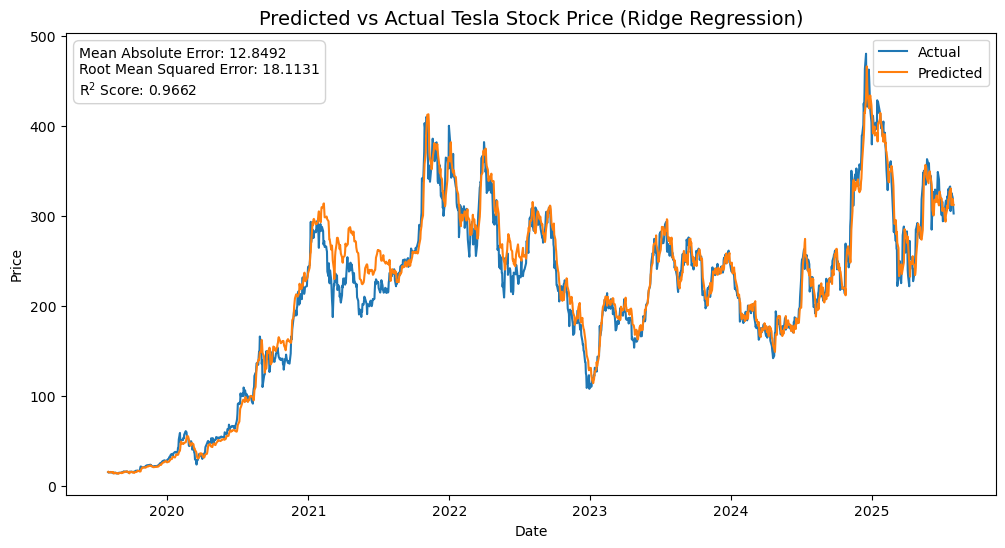

In [36]:
rr_results = test_model(df, rr_model, predictors, algo_name="Ridge Regression", hypertune=False)
rr_metrics = evaluate_model(rr_results, algo_name="Ridge Regression", hypertune=False)
scores["Ridge Regression"] = rr_metrics

### Hypertuned Ridge Regression

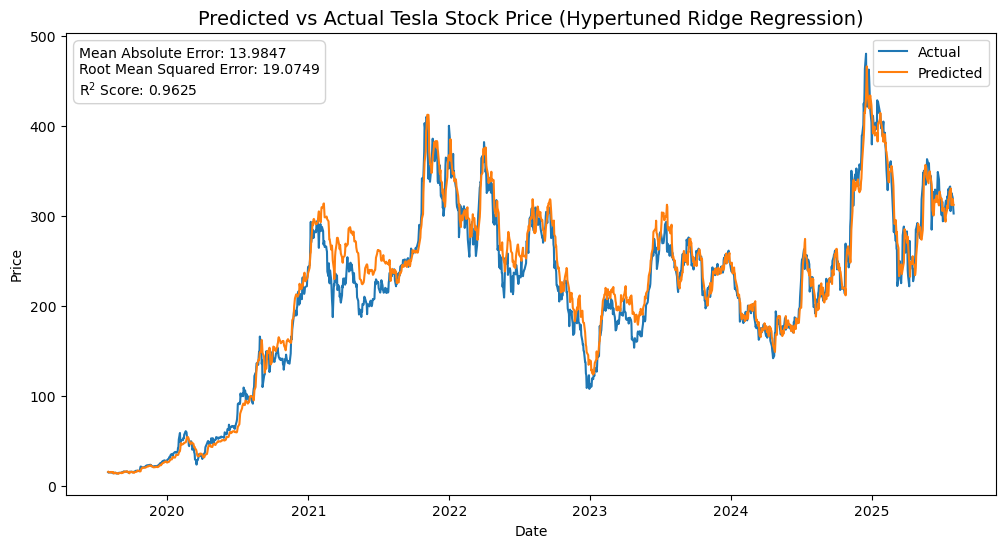

In [37]:
ht_rr_results = test_model(df, rr_model, predictors, algo_name="Ridge Regression", hypertune=True)
ht_rr_metrics = evaluate_model(ht_rr_results, algo_name="Ridge Regression", hypertune=True)
scores["Hypertuned Ridge Regression"] = ht_rr_metrics

### Random Forest

The next regression algorithm I've chosen for this project is random forest. This is because of its effectiveness in capturing nonlinear relationships and its ability to account for interactions between features. Random forest should complement the results of ridge regression nicely.

In [38]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, random_state=1)

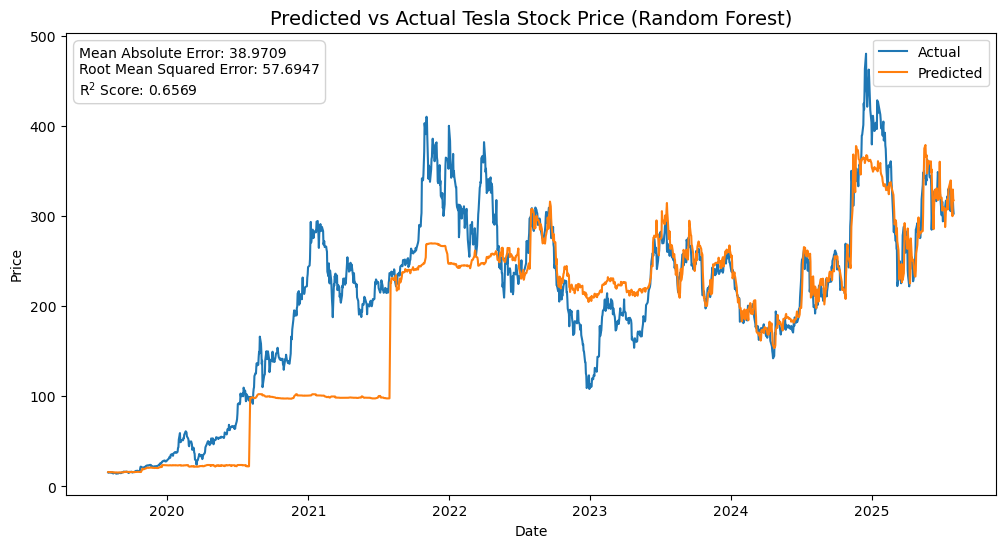

In [39]:
rf_results = test_model(df, rf_model, predictors, algo_name="Random Forest", hypertune=False)
rf_metrics = evaluate_model(rf_results, algo_name="Random Forest", hypertune=False)
scores["Random Forest"] = rf_metrics

### Hypertuned Random Forest

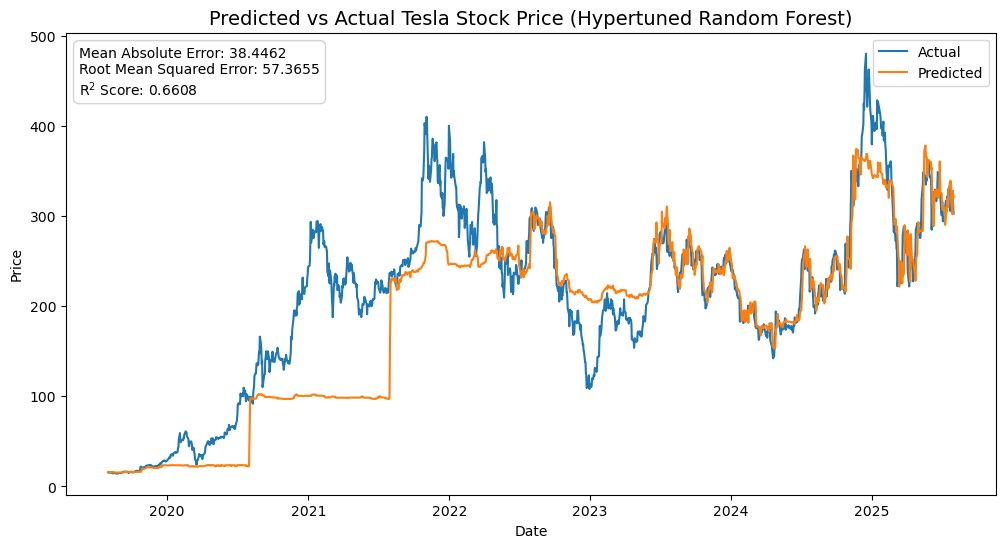

In [40]:
ht_rf_results = test_model(df, rf_model, predictors, algo_name="Random Forest", hypertune=True)
ht_rf_metrics = evaluate_model(ht_rf_results, algo_name="Random Forest", hypertune=True)
scores["Hypertuned Random Forest"] = ht_rf_metrics

In [41]:
xgb_model = XGBRegressor()

### XGB

The final regression algorithm I've chosen for this project is the XGB regressor. This is because of its heightened performace and accuracy compared to random forest. The XGB regressor should make for our most accurate model yet.

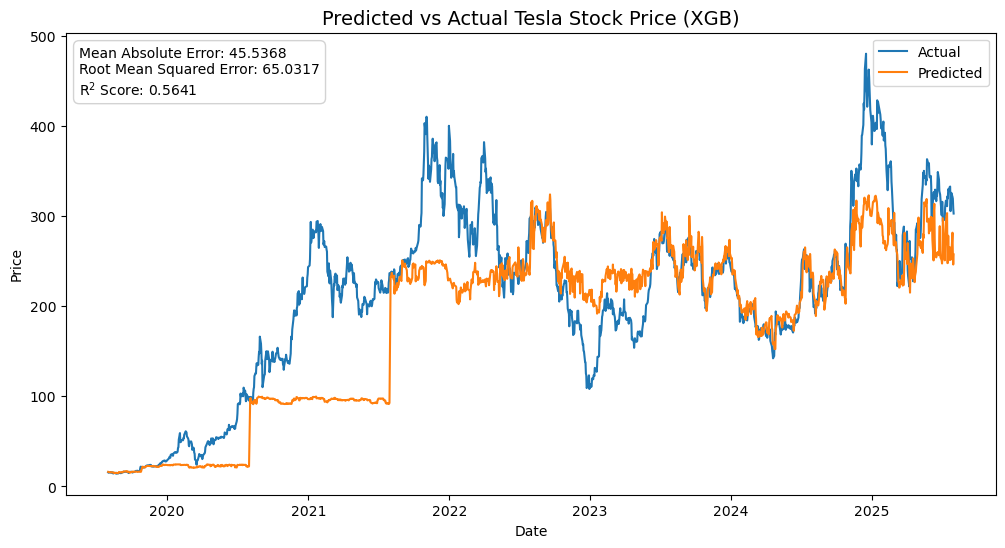

In [42]:
xgb_results = test_model(df, xgb_model, predictors, algo_name="XGB", hypertune=False)
xgb_metrics = evaluate_model(xgb_results, algo_name="XGB", hypertune=False)
scores["XGB"] = xgb_metrics

### Hypertuned XGB

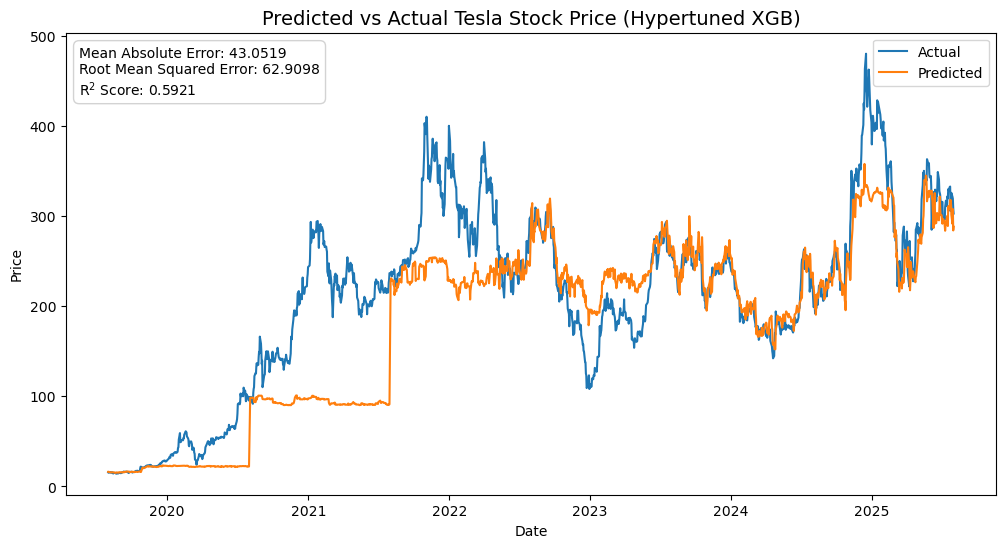

In [43]:
ht_xgb_results = test_model(df, xgb_model, predictors, algo_name="XGB", hypertune=True)
ht_xgb_metrics = evaluate_model(ht_xgb_results, algo_name="XGB", hypertune=True)
scores["Hypertuned XGB"] = ht_xgb_metrics

### Stacked Regressor

The last model I've decided to make is a stacked regression model. In combining the linear strengths of ridge regression, the nonlinear strengths of random forest, and the boosting of XGB, I'm hoping to make our most accurate and best generalizing model.

In [44]:
stack_model = StackingRegressor(
    estimators=[
        ('ridge', rr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=Ridge(alpha=1.0),
    passthrough=True
)

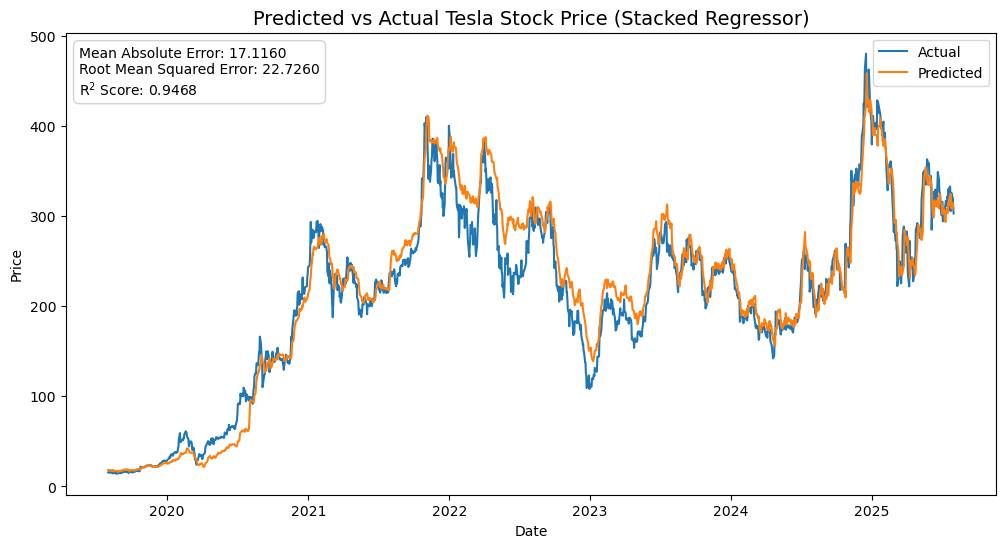

In [45]:
stack_results = test_model(df, stack_model, predictors, algo_name="Stacked Regressor", hypertune=False)
stack_metrics = evaluate_model(stack_results, algo_name="Stacked Regressor", hypertune=False)
scores["Stacked Regressor"] = stack_metrics

## 6. Model Comparison

In [46]:
scores

,Ridge Regression,Hypertuned Ridge Regression,Random Forest,Hypertuned Random Forest,XGB,Hypertuned XGB,Stacked Regressor
Mean Absolute Error,12.849248,13.984699,38.970851,38.446230,45.536814,43.051934,17.115953
Root Mean Square Error,18.113116,19.074913,57.694707,57.365496,65.031671,62.909774,22.726011
R$^2$ Score,0.966184,0.962498,0.656914,0.660819,0.564107,0.592088,0.946767


Despite my good intentions, our models are not performing very well. Firstly, our ridge regression models, which are characterized by sky-high R$^2$ scores, are most likely overfitting. Similarly, our random forest and XGB models, which have MAE and RMSE values that exceed certain valuations of our stock, are most likely underfitting. In an effort to find a happy medium, we made a stacking regressor model, and while that resulted in slightly moderated MAE and RMSE values, it still left us with an unusually high R$^2$ score.

Futhermore, our model are having issues dealing with the temporal nature of the data. As seen in some of the graphs (specifically the random forest and XGB ones), predictions made on early data points are severly underfitted, while predictions made on later data points are clearly overfitted. Only in the middle data points, and in periods of stock consolidation, did our models make effective generalizations.

# Conclusion

In this project, we aimed to predict the price fluctations of Tesla stock. This was done with thorough data preprocessing and feature engineering. Below are my thoughts and conclusions from the overall process.

 - **Data Exploration:** Through a brief examination, I gained insights into the characteristics and quality of our dataset.
 - **Data Preprocessing:** Various transformations, such as renaming columns and adding our target variable, were performed to prepare the dataset for modeling.
 - **Feature Engineering:** Further transformations, such as adding technical indicators and calculating moving averages, were performed to increase the accuracy of our models. 
 - **Model Implementation:** I constructed six classification models, three with hyperparameter tuning and three without, before finishing by making a stacked regressor model. The models chosen for initial testing--ridge regression, random forest, and XGB--were chosen for their unique but complimentary strengths in dealing with this kind of data.
 - **Model Comparison:** After evaluating each model on the appropriate metrics, and taking overfitting and underfitting into account, I concluded that the stacked regressor model was our most effective model at generalizing the stock data.

In conclusion, this project was quite challenging. It's hard to predict stock market movement with just technical indicators, as there are many external factors that can cause movement but can't be accounted for. Additionally, with so little data to work with, our models struggled to make generalizations, and were very prone to overfitting and underfitting. Still, creating this project was very insightful, as I learned a lot about feature engineering, working with temporal data, and dealing with overfitting. In the future, I hope to improve this models ability to generalize, and to potentially make predictions on future stock movement.